# Model 1

- Use log(Percent_Allocation*100) as Y
- Use Total_HDD and Total_CDD, not lagged variables
- Include all other predictors in the mode

*Performance*
- Best model: Bagging Regressor
- MSE: 0.020184775257213204
- R-Squared: 0.9800792336012418
- Highest permuatation importance: `Total_Exp`

# Dependencies

In [1]:
# Data Management/Investigation
import os
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

os.chdir('/Users/Alia/Documents/Github/FinalProjectPPOL564/Clean_Data')

# Data

LIHEAP variables collected 

In [2]:
# Data on state-year LIHEAP eligibility, energy prices, energy consumption, etc.
dat = pd.read_csv("Complete_Data.csv")
dat.shape

(714, 40)

In [3]:
# Available features
list(dat)

['Year',
 'State',
 'State_Year',
 'Eligible_Households',
 'Total_HDD',
 'Total_CDD',
 'Lag_HDD',
 'Lag_CDD',
 '30NormHDD',
 'LI_Coal_Heaters',
 'LI_NG_Heaters',
 'LI_FO_KE_Heaters',
 'LI_LPG_Heaters',
 'LI_EL_Heaters',
 'LI_Wood_Heaters',
 'Coal_Consumed',
 'FO_Consumed',
 'EL_Consumed',
 'LPG_Consumed',
 'KE_Consumed',
 'NG_Consumed',
 'Total_Energy_Consumed',
 'Wood_Consumed',
 'Coal_Exp',
 'FO_Exp',
 'EL_Exp',
 'LPG_Exp',
 'KE_Exp',
 'NG_Exp',
 'Total_Exp',
 'Wood_Exp',
 'Coal_Price',
 'FO_Price',
 'EL_Price',
 'LPG_Price',
 'KE_Price',
 'NG_Price',
 'Total_Avg_Price',
 'Wood_Price',
 'Percent_Allocation']

Look at **missingness** in the data. Amazing! No missingness!

<AxesSubplot:>

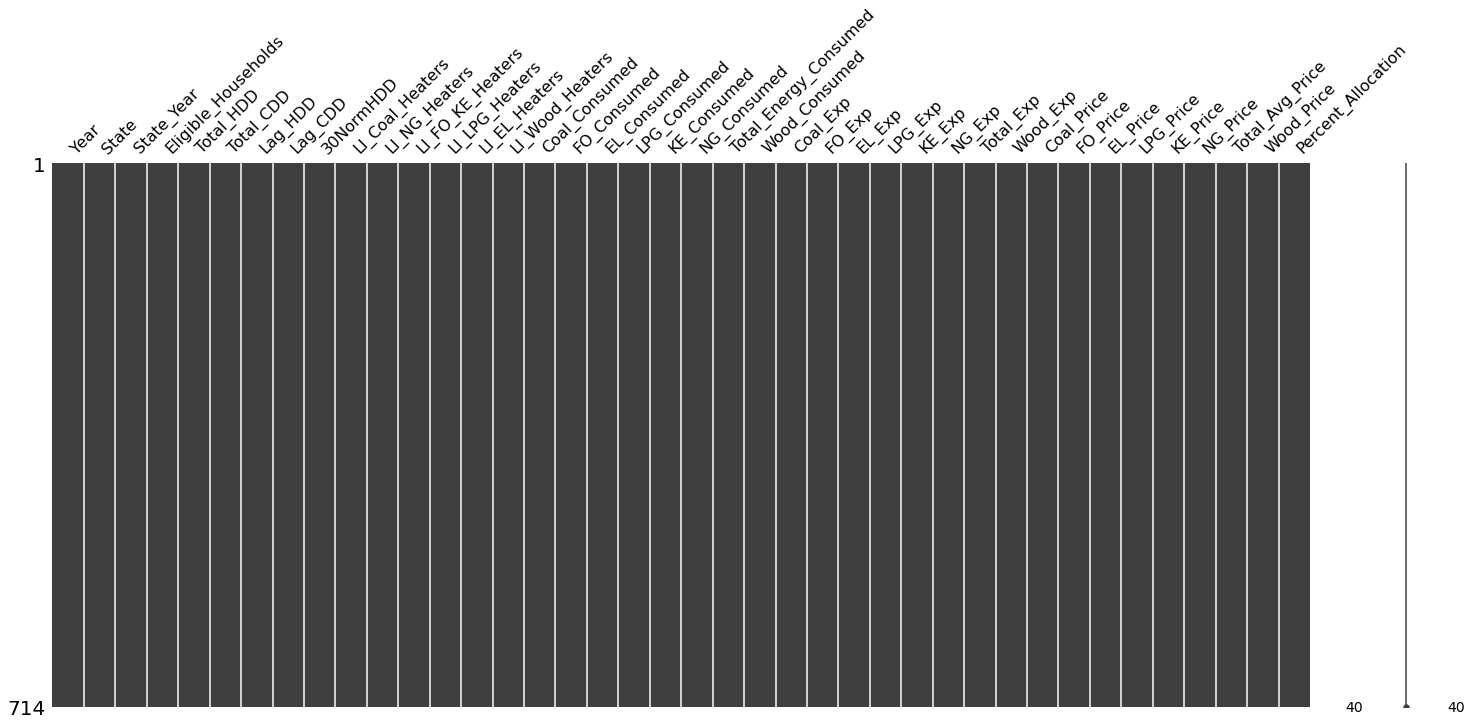

In [4]:
miss.matrix(dat)

In [5]:
dat.dtypes

Year                       int64
State                     object
State_Year                object
Eligible_Households        int64
Total_HDD                  int64
Total_CDD                  int64
Lag_HDD                  float64
Lag_CDD                  float64
30NormHDD                  int64
LI_Coal_Heaters            int64
LI_NG_Heaters              int64
LI_FO_KE_Heaters           int64
LI_LPG_Heaters             int64
LI_EL_Heaters              int64
LI_Wood_Heaters            int64
Coal_Consumed            float64
FO_Consumed              float64
EL_Consumed              float64
LPG_Consumed             float64
KE_Consumed              float64
NG_Consumed              float64
Total_Energy_Consumed    float64
Wood_Consumed            float64
Coal_Exp                 float64
FO_Exp                   float64
EL_Exp                   float64
LPG_Exp                  float64
KE_Exp                   float64
NG_Exp                   float64
Total_Exp                float64
Wood_Exp  

Set up data in the **SKLEARN framework** (i.e. outcome separated from the predictors).

In [6]:
y = dat['Percent_Allocation'] # OUTCOME: The percent allocation of LIHEAP funds to each state in that year
# PREDICTORS: all except the outcome and non-predictive identifiers
# Use Total_HDD and Total_CDD instead of Lag
X = dat.drop(columns=['Percent_Allocation','State','Year','State_Year','Lag_HDD','Lag_CDD']) 

Split the data 

In [7]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

## Explore the training data 

In [8]:
# Look at the training data
train_X.shape 

print(train_X.shape[0]/dat.shape[0])
print(test_X.shape[0]/dat.shape[0])

# Create a copy of training data to avoid visualizing test data
d = train_X.select_dtypes(include=["int","float"]).melt()

0.7492997198879552
0.2507002801120448


How is the data distributed?

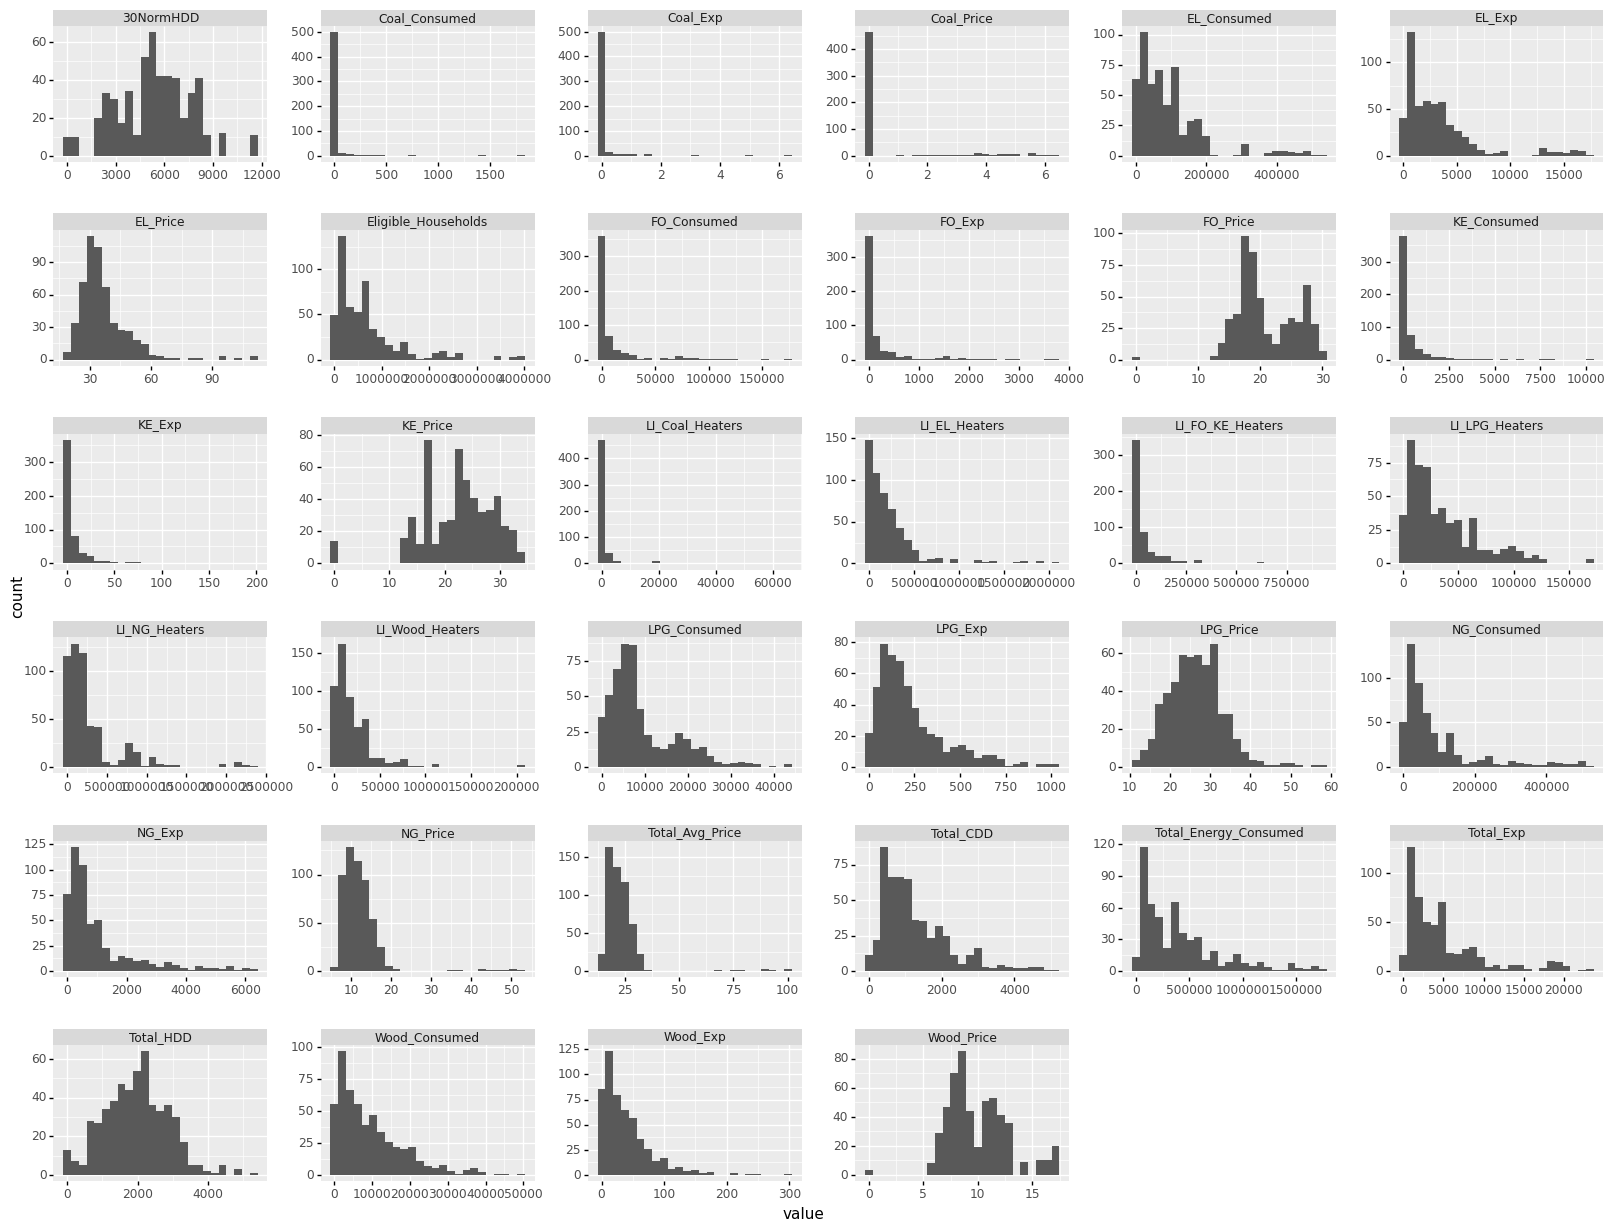

In [9]:
g = (
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(20,15),
          subplots_adjust={'wspace':.25,'hspace':.5})
) 

print(g)

Insights:
- Scale will be an issue. So we need to pre-process
- `KE_Price` and `Wood_Price` follow a binomial distribution

Look at the outcome `Percent_Allocation` and see if there is any red flags. 

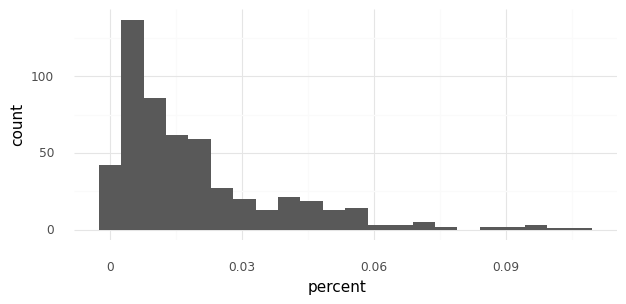

<ggplot: (8763714338298)>

In [10]:
(
    ggplot(pd.DataFrame(dict(percent=train_y)),
           aes(x="percent")) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (7,3)) 
)

It looks like there are some percents that are less than 0, which shouldn't be possible. Let's check summary statistics on the entire dataset.

In [11]:
dat['Percent_Allocation'].min()

0.000980376

Alright, so it's not 0 but it is a *very* small number. It seems like this will make predictions difficult, so let's multiply by 100.

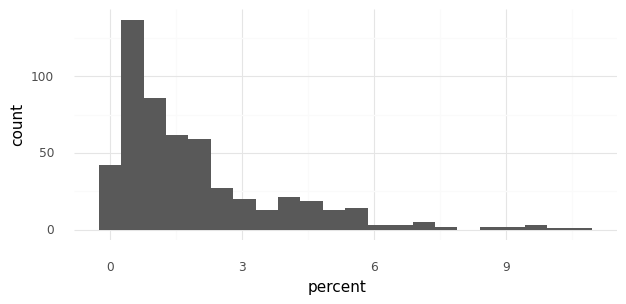

<ggplot: (8763722178018)>

In [12]:
y = dat['Percent_Allocation']*100

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

(
    ggplot(pd.DataFrame(dict(percent=train_y)),
           aes(x="percent")) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (7,3)) 
)

In [13]:
train_y.min()

0.0980376

We can see that the actual min is 0.099. It seems like the plot is just incorrectly showing a value less than 0.

But, we can definitely see that the distribution is right-skewed. Let's try a log transformation.

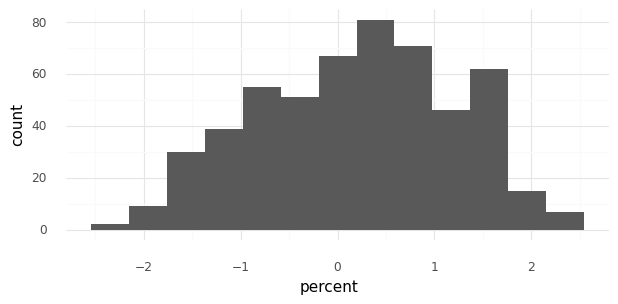

<ggplot: (8763715812265)>

In [14]:
y = np.log(dat['Percent_Allocation']*100)

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

(
    ggplot(pd.DataFrame(dict(percent=train_y)),
           aes(x="percent")) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (7,3)) 
)

That looks a lot better! This makes sense; without hold harmless measures, most states get a very small allocation based on the formula. 

Let's just look at how our predictors relate to the outcome.

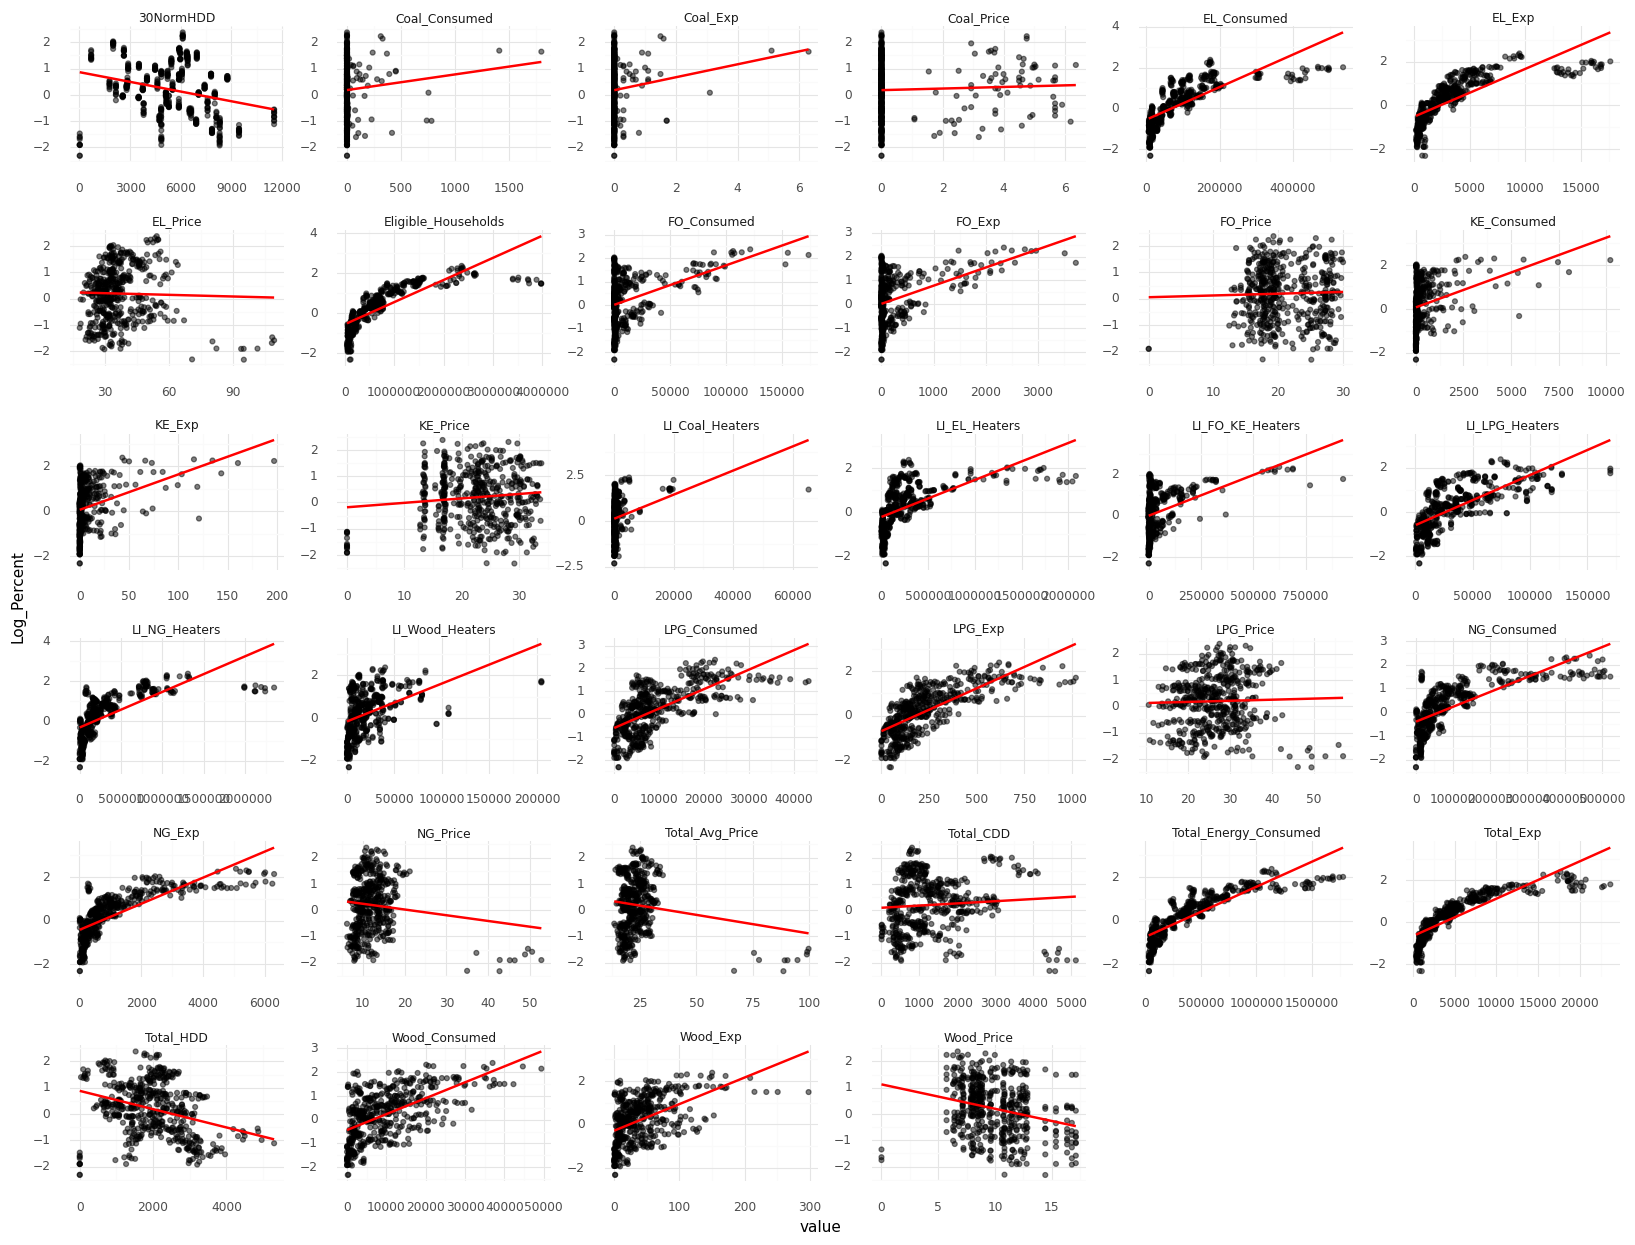

<ggplot: (8763722179542)>

In [15]:
D = train_X.copy()
D['Log_Percent'] = train_y

(
    ggplot(D.melt(id_vars=["Log_Percent"]),
           aes(x="value",y="Log_Percent"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
     theme(figure_size=(20,15),
          subplots_adjust={'wspace':.25,'hspace':.5}) 
)

## Pre-Processing

Let's rescale our training data for now, but we'll put the preprocessing into a modeling pipeline later on.

In [16]:
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [17]:
# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,Eligible_Households,Total_HDD,Total_CDD,30NormHDD,LI_Coal_Heaters,LI_NG_Heaters,LI_FO_KE_Heaters,LI_LPG_Heaters,LI_EL_Heaters,LI_Wood_Heaters,...,Total_Exp,Wood_Exp,Coal_Price,FO_Price,EL_Price,LPG_Price,KE_Price,NG_Price,Total_Avg_Price,Wood_Price
0,0.048636,0.340253,0.219707,0.458583,0.033188,0.036913,0.007517,0.052797,0.055087,0.085609,...,0.054509,0.106269,0.0,0.625166,0.161863,0.443917,0.673952,0.062527,0.105863,0.497370
1,0.186983,0.313455,0.216195,0.387484,0.052282,0.070298,0.127751,0.216904,0.140258,0.385903,...,0.270033,0.170634,0.0,0.557257,0.141151,0.350086,0.639398,0.153631,0.118427,0.470485
2,0.026502,0.465560,0.102049,0.657714,0.001682,0.013265,0.070946,0.103757,0.006429,0.051539,...,0.050621,0.118337,0.0,0.502330,0.390904,0.399914,0.376846,0.163730,0.146463,0.334892
3,0.020452,0.000000,0.913561,0.000000,0.000000,0.000194,0.000022,0.004952,0.017240,0.003210,...,0.028235,0.009051,0.0,0.930426,0.990247,0.977135,0.953633,0.931027,1.000000,0.954997
4,0.163924,0.547462,0.085659,0.675445,0.001468,0.172693,0.074346,0.389893,0.071352,0.131794,...,0.183887,0.209521,0.0,0.581891,0.261260,0.131579,0.494979,0.040180,0.063867,0.472238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,0.014038,0.252500,0.297171,0.410256,0.002752,0.009882,0.021408,0.060953,0.011979,0.004861,...,0.025250,0.020114,0.0,0.821904,0.240548,0.455997,0.779976,0.187581,0.185086,0.667446
531,0.130663,0.221740,0.252683,0.399478,0.045127,0.074401,0.009664,0.211798,0.144388,0.112932,...,0.130845,0.094536,0.0,0.595872,0.129534,0.205134,0.501181,0.095187,0.102955,0.489188
532,0.219367,0.306473,0.307512,0.387484,0.017473,0.087549,0.078119,0.228924,0.268977,0.178213,...,0.299468,0.159906,0.0,0.636485,0.177205,0.483175,0.717070,0.104426,0.138553,0.517241
533,0.206761,0.367428,0.169756,0.555324,0.015394,0.177881,0.229448,0.135273,0.085899,0.051202,...,0.261836,0.097888,0.0,0.533955,0.410849,0.506687,0.400473,0.126343,0.130060,0.334892


# Modeling

The problem that we're working on is a **regression problem** (i.e. we have a continuously distributed outcome variable). We've played around with a few models that can tackle problems such as these. 

- Linear Regression 
- KNN
- Decision Trees
- Bagging 
- Random Forest

Luckily, implementing each of these (very different) algorithms is straight-forward using the `sklearn` API. 

For each model, we'll use **K-fold cross-validation** to estimate the test error. As we saw a few weeks back, we can do this easily with the `cross_validate` method. We'll use **5 folds** when cross-validating.

Recall that in order to make valid comparisons across models, we need to use the same data splits for each fold. We can do this by creating a KFold generator that will ensure we're using the same break points when training the model. 

In [18]:
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1997)

Let's run each model individually (using defaults for any tuning parameters... more on this later); let's then compare the performance of the different models in a plot.

We'll use **mean squared error** as our performance metrics.

In [19]:
use_metrics = ["neg_mean_squared_error"]

## Run the Models

### Linear Model

In [20]:
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

### KNN

In [21]:
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

### Decision Tree

In [22]:
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

#### Side Note: Plotting a Decision Tree
First, a quick side note on the decision trees. When we built a tree from scratch, we discussed looking at the **decision rules** of the tree. There is a very straight forward way of doing this in `sklearn`.

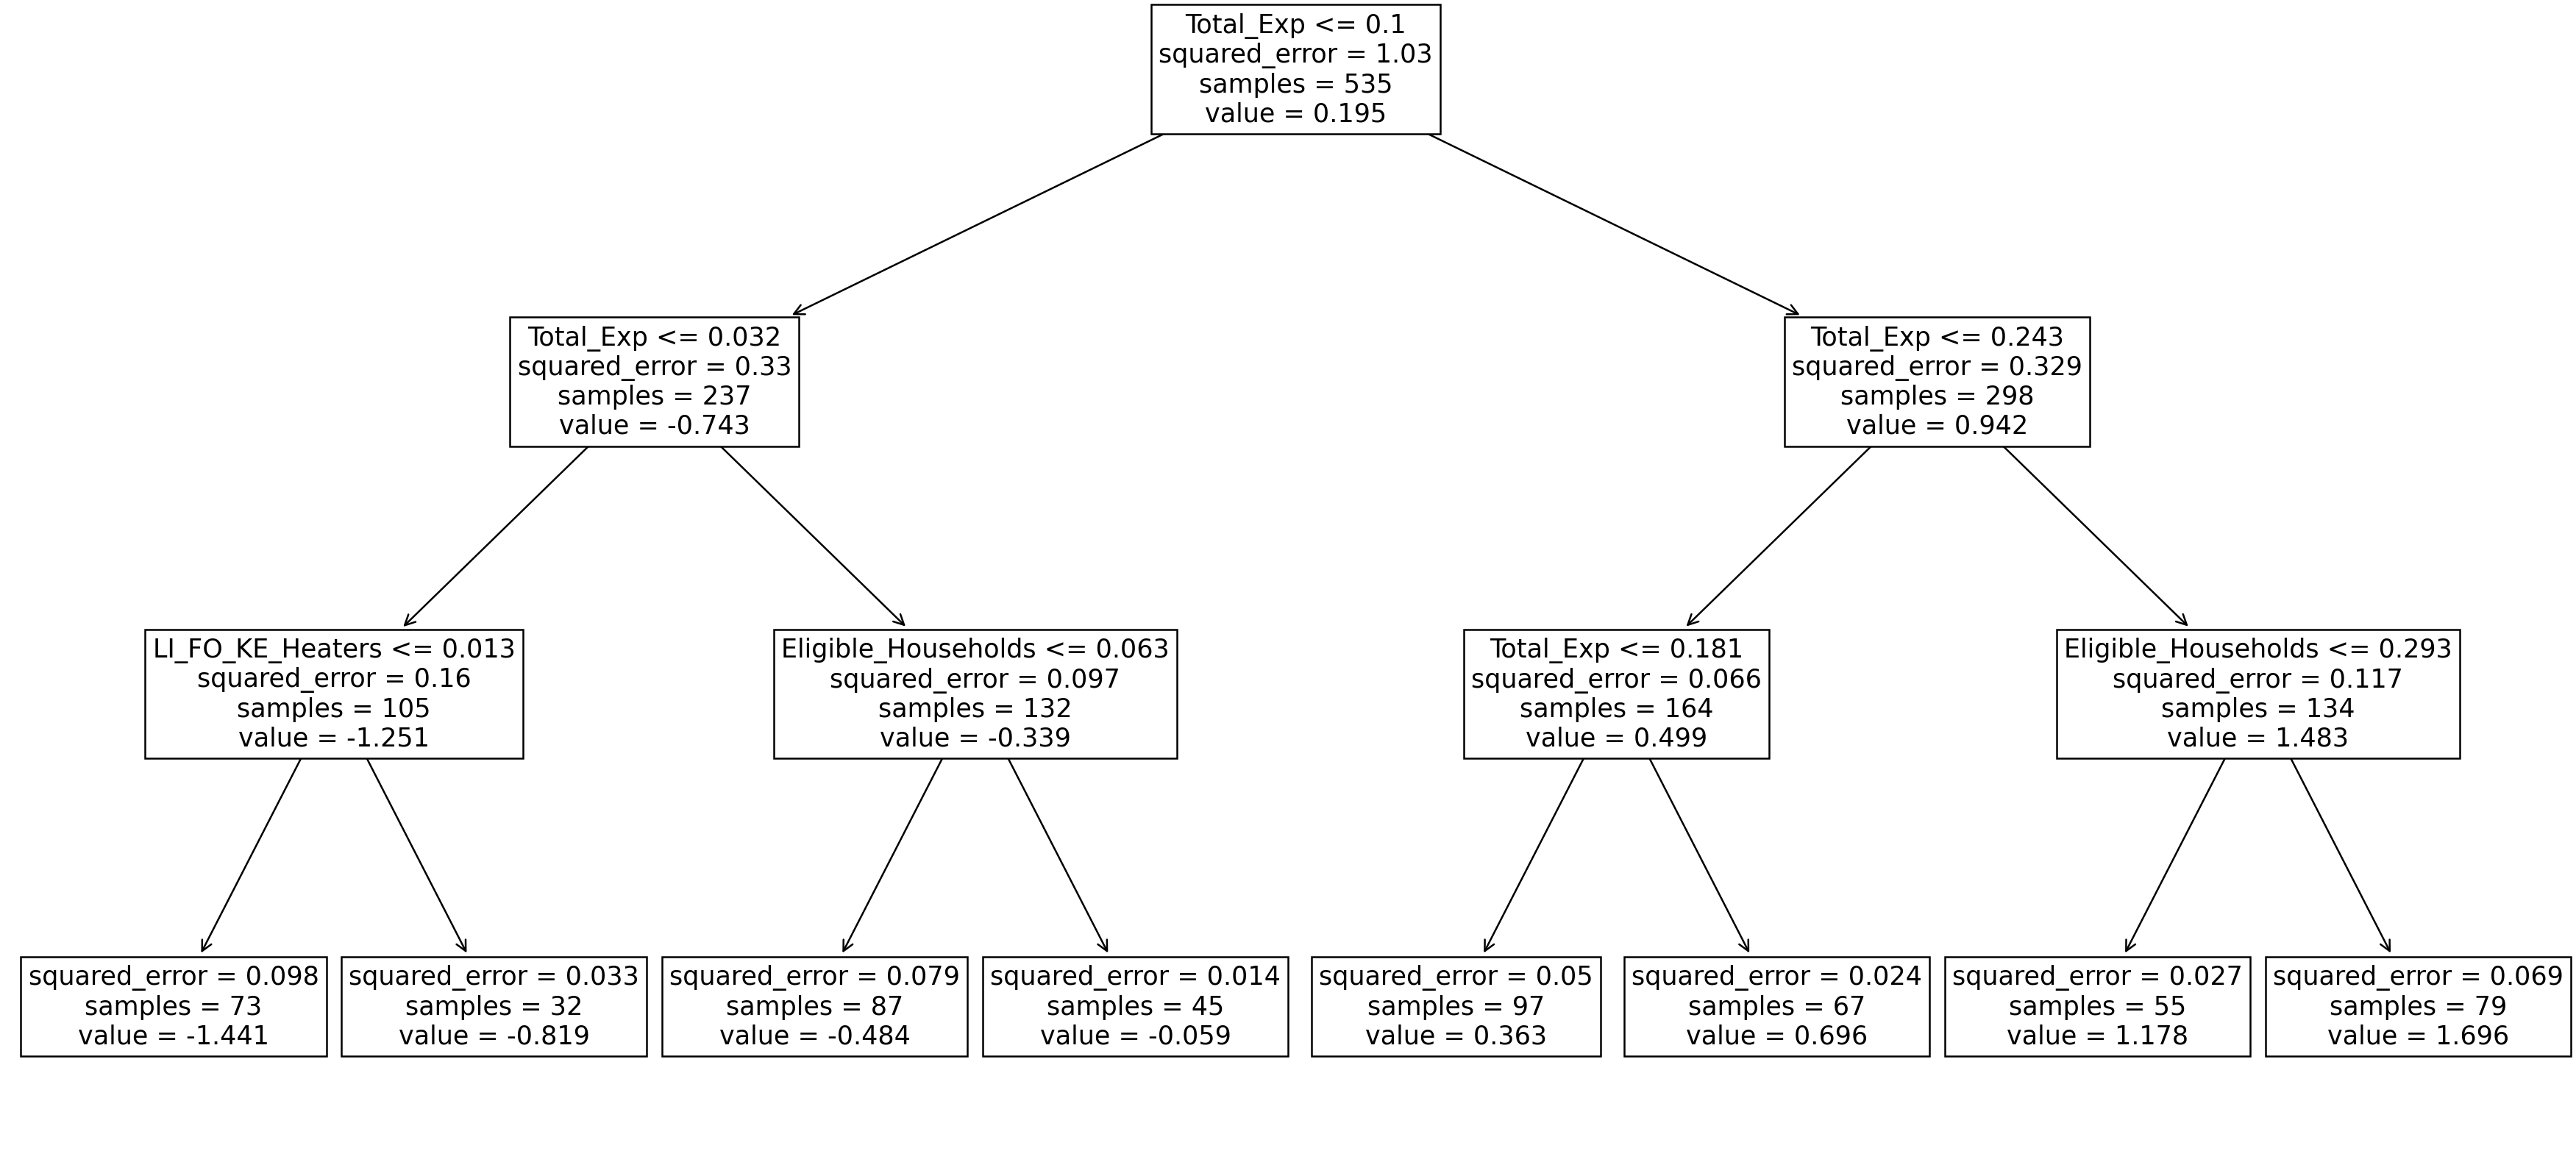

In [23]:
mod = DTree(max_depth=3) # Initialize the modeling object (just as we did)
mod.fit(train_X,train_y) # Fit the mode

# Plot the tree
plt.figure(figsize=(10,5),dpi=180)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=14)

### Bagging

In [24]:
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

### Random Forest

In [25]:
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

## Compare Models

In [26]:
# Output is a dictionary 
lm_scores

{'fit_time': array([0.013026  , 0.00776005, 0.00774813, 0.004951  , 0.00311804]),
 'score_time': array([0.00479126, 0.00848007, 0.0033102 , 0.00236607, 0.00200677]),
 'test_neg_mean_squared_error': array([-0.12263121, -0.08491466, -0.15562133, -0.13606009, -0.12201993])}

We can collect the scores of the metrics we care about. 

In [27]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.122631
1,lm,0.084915
2,lm,0.155621
3,lm,0.136060
4,lm,0.122020
5,knn,0.042526
6,knn,0.044630
7,knn,0.051777
8,knn,0.043870
9,knn,0.046899


And plot!

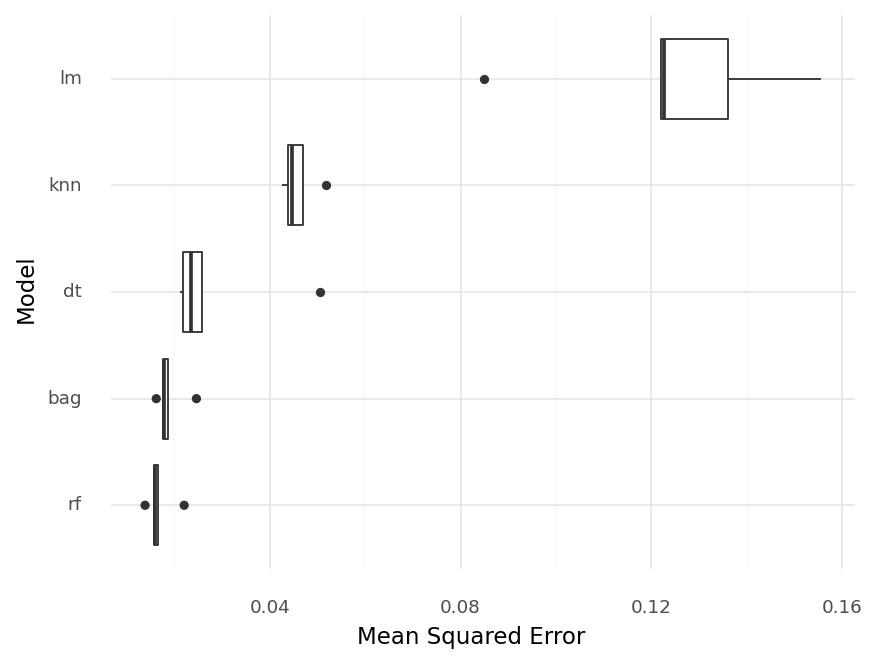

<ggplot: (8763723507026)>

In [28]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

Lower is better. The random forest appears to do the best here.  

# Tuning Hyper-parameters

As we learned this week in the synchronous lectures, there are a number of parameters that we can tweak/tune that will change our model's performance.

For example, recall the K-Nearest Neighbors model. The value we set `k` (or `n_neighbors` in `sklearn`) at (i.e. how many neighbors in the training data that we look at when making our prediction for the test data) determines the degree to which we **overfit** or **underfit** the data.

In [29]:
set_k = dict()
for k in [1,5,10,50,100,250]:
    score = cross_validate(KNN(n_neighbors=k),
                           train_X,train_y, 
                           cv = fold_generator, 
                           scoring =use_metrics)
    s = score['test_neg_mean_squared_error']
    set_k[k] = s.mean()
 
set_k

{1: -0.03518372598013023,
 5: -0.045940239211655146,
 10: -0.06376540317126936,
 50: -0.1895300384600926,
 100: -0.28189952505807503,
 250: -0.5707018704449809}

As we can see from the above example, when we set higher values of `k`, we get a better out of sample fit (`k = 1` being the worse), but after `k = 50`, we shift out of overfitting territory and into underfitting territory. So choosing the right value of `k` is crucial to making this method work.

**Let's learn how to systematically tune parameters using `sklearn`'s `GridSearchCV`.**

## `GridSearchCV`

A Grid search performance an exhaustive search over specified parameter values for an estimator. That is, we specify all potential values our tuning parameter can take on and then we use cross-validation to compare the out-of-sample performance for different parameter configurations. The result is that we can identify the parameter that performs best.

To list off all the parameters for a model:

In [30]:
mod = KNN() # Initialize the model class
mod.get_params() # report all the available tunning parameters 

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

We can read `sklearn`'s documentation to learn what each parameter does. But for now, let's focus on `n_neighbors`.

For the grid search, we just need to pass it a dictionary of all the tuning parameter values that we want to explore.

In [31]:
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}

From there we wrap the model method in the `GridSearchCV()` class. Note `n_jobs` just tells `sklearn` the number of cores to use on your computer to run the model. Since we're running the same model many times under different configurations, we can parallelize the process so it runs quicker. 

In [32]:
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

We then `.fit()` the model as per usual

In [33]:
tune_knn.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1997, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [1, 10, 25, 35, 50, 75, 100, 250]},
             scoring='neg_mean_squared_error')

Once fit, the model reports back the best fitting parameters.

In [34]:
tune_knn.best_params_

{'n_neighbors': 1}

In [35]:
tune_knn.best_score_

-0.03518372598013023

We can also gather information on the other attempts

In [36]:
tune_knn.cv_results_

{'mean_fit_time': array([0.00559182, 0.00615411, 0.00662694, 0.00684938, 0.01857123,
        0.01269517, 0.00985575, 0.00448179]),
 'std_fit_time': array([0.00054729, 0.00113234, 0.00190953, 0.0029241 , 0.00205788,
        0.01001566, 0.00506919, 0.00106311]),
 'mean_score_time': array([0.00705042, 0.0085856 , 0.00668087, 0.01159029, 0.01318731,
        0.02132692, 0.01257458, 0.00716028]),
 'std_score_time': array([0.00084895, 0.00106369, 0.00037672, 0.00368595, 0.00456962,
        0.01341952, 0.00600188, 0.00134005]),
 'param_n_neighbors': masked_array(data=[1, 10, 25, 35, 50, 75, 100, 250],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 10},
  {'n_neighbors': 25},
  {'n_neighbors': 35},
  {'n_neighbors': 50},
  {'n_neighbors': 75},
  {'n_neighbors': 100},
  {'n_neighbors': 250}],
 'split0_test_score': array([-0.03400862, -0.07064133, -0.15938292, -0.198

## Model Tuning 

With the above in hand, let's tune our hyperparameters for our various models. We've already tuned our KNN. Let's do the same for the other models. (_Note_: For the linear model, there are no hyperparameters, and Bagging is an ensemble approach rather than it's own model, so we won't consider it in our tune.)

### Decision Tree

All the parameters for a decision tree. Let's focus on `max_depth`. 

In [37]:
DTree().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [38]:
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [39]:
tune_dt.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1997, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [40]:
tune_dt.best_params_

{'max_depth': 6}

In [41]:
tune_dt.best_score_

-0.024662740600591197

### Random Forest

For the random forest, we see many of the same parameters as a decision tree, which makes sense given how the random forest works. We'll focus on `max_depth` and `n_estimators` (i.e. the number of trees to grow and ensemble across) and `max_features` (i.e. the number of predictors to consider when growing each tree). 

Note that there are only three features here, so there is only so much the randomness in the Random Forest will help out, but as the feature space grows, Random Forest becomes a very useful learning method.

In [42]:
RF().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [43]:
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
              'max_features': [5,10,20,30,34]} # We have 34 total 
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [44]:
# This model will take longer to run given all the tuning parameters we're exploring
tune_rf.fit(train_X,train_y) 

GridSearchCV(cv=KFold(n_splits=5, random_state=1997, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [1, 2, 3],
                         'max_features': [5, 10, 20, 30, 34],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [45]:
tune_rf.best_params_

{'max_depth': 3, 'max_features': 10, 'n_estimators': 100}

In [46]:
tune_rf.best_score_

-0.05077814911024847

# Modeling Pipeline

Let's piece together all these steps as one seamless pipeline!

In [47]:
# (0) Split the data 
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1997)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), list(X.columns))])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1997, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Eligible_Households',
                                                                          'Total_HDD',
                                                                          'Total_CDD',
                                                                          '30NormHDD',
                                                                          'LI_Coal_Heaters',
                                                                          'LI_NG_Heaters',
                                                                          'LI_FO_KE_Heaters',
                                                                        

Let's look at the best fit score from the scan.

In [48]:
search.best_score_ # Mean out-of-sample (CV) error

-0.02172028551848746

Look at the best model

In [49]:
search.best_params_

{'model': BaggingRegressor()}

In [50]:
bag_mod = search.best_estimator_

# Test Performance

Let's assume that our work is all done. We scanned the tuning parameters for all our candidate models and found the best performing model. Let's now see how well it does on the test data that it wasn't trained on. 

Note that our new data is automatically preprocessed before being fit thanks to setting everything up as a pipeline!

In [51]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [52]:
m.mean_squared_error(test_y,pred_y)

0.020184775257213204

In [53]:
m.r2_score(test_y,pred_y)

0.9800792336012418

Visualize

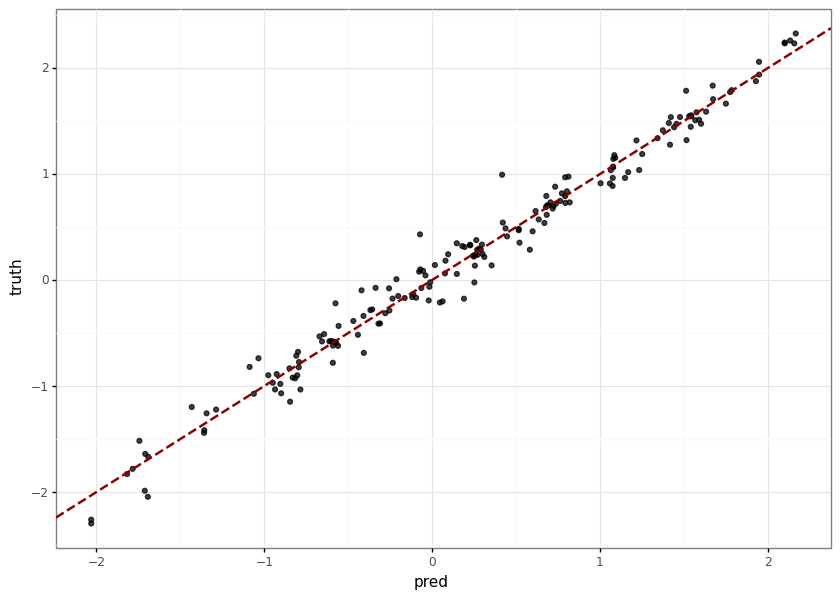

<ggplot: (8763722127650)>

In [54]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

# Model Interpretation
## Permutation Importance

Permute the features to determine importance

In [55]:
vi = permutation_importance(bag_mod,train_X,train_y,n_repeats=30)

In [56]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,Total_Exp,1.499052,0.065067,1.368918,1.629185
1,LI_FO_KE_Heaters,0.028562,0.002722,0.023118,0.034006
2,Eligible_Households,0.021103,0.001341,0.018421,0.023784
3,FO_Consumed,0.008980,0.001111,0.006757,0.011203
4,Total_Energy_Consumed,0.005618,0.000367,0.004885,0.006352
5,EL_Consumed,0.005565,0.000693,0.004179,0.006952
6,LI_LPG_Heaters,0.005500,0.000992,0.003516,0.007484
7,LI_NG_Heaters,0.004085,0.000290,0.003506,0.004665
8,FO_Exp,0.002495,0.000404,0.001687,0.003303
9,LI_Wood_Heaters,0.001521,0.000169,0.001183,0.001859


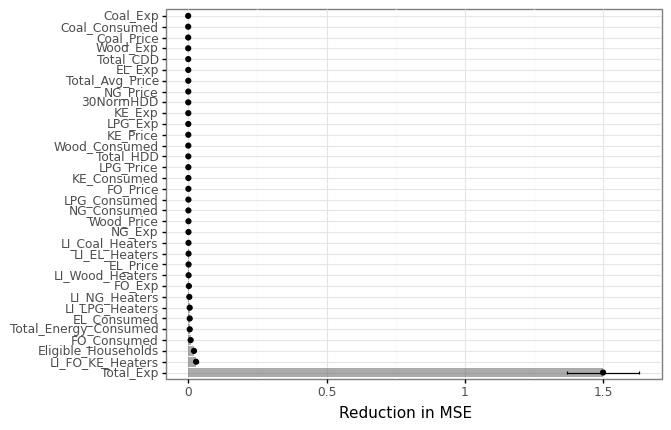

<ggplot: (8763721794711)>

In [57]:
# Visualize permutation importance
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in MSE",x="")
)

## Partial Dependency Plots

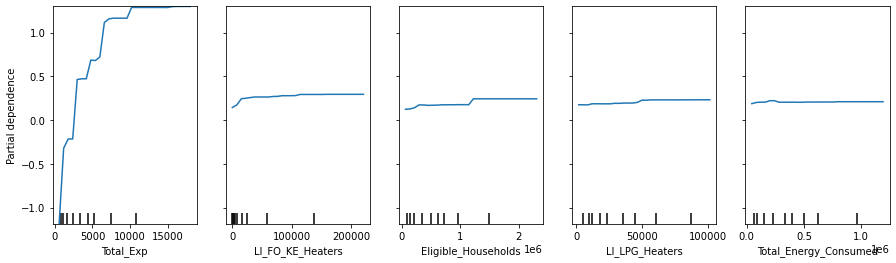

In [58]:
# Target specific features
features = ['Total_Exp','LI_FO_KE_Heaters','Eligible_Households','LI_LPG_Heaters','Total_Energy_Consumed']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(15, 4))
display = plot_partial_dependence(
    bag_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)
# display.figure_.set_figwidth(15)
# display.figure_.set_figheight(4)

### Interaction Partial Dependency Plots (2D)

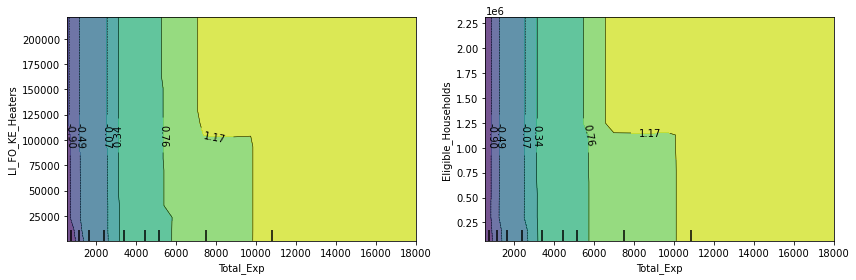

In [59]:
# Feed in the ineraction as a nested list
interacted_features = [['Total_Exp','LI_FO_KE_Heaters'],['Total_Exp','Eligible_Households']] 

# Plot
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    bag_mod, train_X, interacted_features,
    n_cols=3,n_jobs=4, grid_resolution=20,ax=ax
)
fig.tight_layout()

### ICE Plots

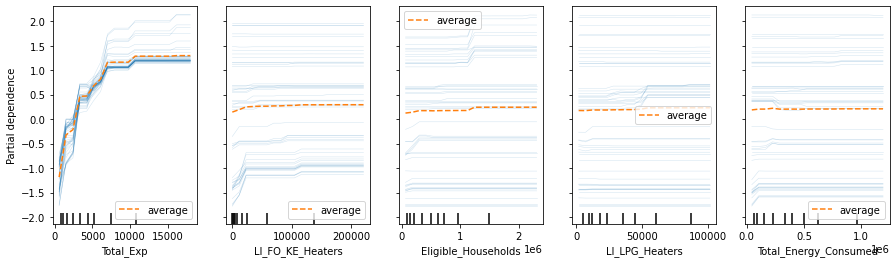

In [60]:
features = ['Total_Exp','LI_FO_KE_Heaters','Eligible_Households','LI_LPG_Heaters','Total_Energy_Consumed']
fig, ax = plt.subplots(figsize=(15, 4))
display = PartialDependenceDisplay.from_estimator(
    bag_mod,
    train_X,
    features,
    kind="both", # "average" = just PDP, "individual" = just ICE
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    n_cols=len(features),
    ax = ax
)
display.figure_.subplots_adjust(hspace=0.7)